# Comparison of ways of separating data into test- and trainsets
comparison of both 
- Hold-out, as in usage of sklearn's train_test_split
- Cross Validation, as in usage of sklearn's StratifiedKFold


https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f

In [18]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, naive_bayes, svm, tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import export_graphviz
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

categories = pickle.load(open("darkweb/data/pekelbad/categorieen.pkl", "rb"))
tfvector = pickle.load(open("darkweb/data/pickle/tfidf_vectors.pkl", "rb"))
random = 42 #hardcoded to maintain results

df = pd.DataFrame({"Category":categories}) #for usage of Kfold
df["CategoryID"] = df.Category.astype("category").cat.codes

In [2]:
transformers = [
    ('Linear SVC', svm.LinearSVC()),
    ('Multinomial Naive Bayes', naive_bayes.MultinomialNB()),
    ('Gaussian Naive Bayes', naive_bayes.GaussianNB()),
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree', tree.DecisionTreeClassifier()),
    ('SGD', SGDClassifier()),
    ('KNeighbors', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression()),
]

## Training models using Hold-out method

Hold-out is when you split up your dataset into a ‘train’ and ‘test’ set. The training set is what the model is trained on, and the test set is used to see how well that model performs on unseen data. A common split when using the hold-out method is using 80% of data for training and the remaining 20% of the data for testing.

In [3]:
results_HO = []
for transformerName, transform in transformers:
        print('learning ' + transformerName + '...')
        try:
            X_train, X_test, y_train, y_test = train_test_split(tfvector, categories, test_size=0.33, random_state=random)          
            if transformerName == 'Gaussian Naive Bayes':
                model = transform.fit(X_train.todense(), y_train)
                y_pred = model.predict(X_test.todense())
                results_HO.append(tuple([
                    transformerName,
                    accuracy_score(y_pred, y_test),
                    recall_score(y_pred, y_test, average='weighted'),
                    f1_score(y_pred, y_test, average='weighted')
                ]))
            else:
                model = transform.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                results_HO.append(tuple([
                    transformerName,
                    accuracy_score(y_pred, y_test),
                    recall_score(y_pred, y_test, average='weighted'),
                    f1_score(y_pred, y_test, average='weighted')
                ]))
            print(f1_score(y_pred, y_test, average='weighted'))
        except:
            print('FAILED')
            results_HO.append(tuple([transformerName, 0, 0, 0]))

learning Linear SVC...
0.8634566895491402
learning Multinomial Naive Bayes...
0.7835957838983414
learning Gaussian Naive Bayes...
0.8125811229192027
learning Random Forest...
0.8472608947589737
learning Decision Tree...
0.8212947359197467
learning SGD...
0.8554475702855058
learning KNeighbors...
0.8519283854876076
learning Logistic Regression...
0.8260280735567747


In [4]:
# location = 'results.csv'
# result_array = np.asarray(results)
# np.savetxt(
#     location,
#     result_array,
#     delimiter=",",
#     fmt="%s",
#     comments='',
#     header=','.join(['machine_learning', 'HO_accuracy_score', 'HO_recall_score', 'HO_f1_score'])
# )

## Training models using Stratified KFold method
Cross-validation or ‘k-fold cross-validation’ is when the dataset is randomly split up into ‘k’ groups. One of the groups is used as the test set and the rest are used as the training set. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group as been used as the test set.

In [5]:
results_K = []
y = np.array(df['CategoryID'].tolist())

for transformerName, transform in transformers:
    print('learning ' + transformerName + '...')
    skf = StratifiedKFold(n_splits=10, random_state=random)
    skf.get_n_splits(tfvector, categories)        
    for train_index, test_index in skf.split(tfvector, categories):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X2_train, X2_test = tfvector[train_index], tfvector[test_index]
        y2_train, y2_test = y[train_index], y[test_index]
    try:          
        if transformerName == 'Gaussian Naive Bayes':
            model = transform.fit(X2_train.todense(), y2_train)
            y2_pred = model.predict(X2_test.todense())
            results_K.append(tuple([
                transformerName,
                accuracy_score(y2_pred, y2_test),
                recall_score(y2_pred, y2_test, average='weighted'),
                f1_score(y2_pred, y2_test, average='weighted')
            ]))
        else:
            model = transform.fit(X2_train, y2_train)
            y2_pred = model.predict(X2_test)
            results_K.append(tuple([
                transformerName,
                accuracy_score(y2_pred, y2_test),
                recall_score(y2_pred, y2_test, average='weighted'),
                f1_score(y2_pred, y2_test, average='weighted')
            ]))
        print(f1_score(y2_pred, y2_test, average='weighted'))
    except:
        print('FAILED')
        results_K.append(tuple([transformerName,0,0,0]))

learning Linear SVC...
0.8670946288577871
learning Multinomial Naive Bayes...
0.7931126542363844
learning Gaussian Naive Bayes...
0.7944130961584478
learning Random Forest...
0.8510802076961757
learning Decision Tree...
0.8281959724352038
learning SGD...
0.8673119480930026
learning KNeighbors...
0.8617355271853104
learning Logistic Regression...
0.832839441555754


In [6]:
location = 'results.csv'
result_array = np.asarray(results_HO+results_K)
result_array
np.savetxt(
    location,
    result_array,
    delimiter=",",
    fmt="%s",
    comments='',
    header=','.join(['machine_learning', 'accuracy_score', 'recall_score', 'f1_score'])
)

# Plotting the results

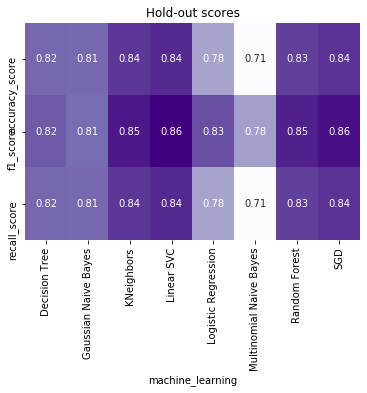

<Figure size 432x288 with 0 Axes>

In [20]:
results = pd.read_csv(location)
results_HO = results[:8]
results_K = results[8:]

plot1 = results_HO.pivot_table(
    columns='machine_learning',
    values=['f1_score','recall_score','accuracy_score']
)

ax = sns.heatmap(plot1, annot=True, cmap="Purples", cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Hold-out scores')
plt.show()
plt.savefig('Holdout_scores.png')

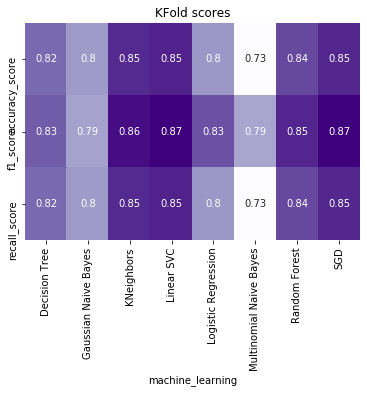

<Figure size 432x288 with 0 Axes>

In [22]:
plot2 = results_K.pivot_table(
    columns='machine_learning',
    values=['f1_score','recall_score','accuracy_score']
)

ax = sns.heatmap(plot2, annot=True, cmap="Purples", cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('KFold scores')
plt.show()
plt.savefig('KFold_scores.png')